# This is the demonstration of how the CNN models learn patterns in the data rather than learning context which can impact in the testing accuracy

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [2]:
dataset = datasets.MNIST('./data', train=False, download=False)

In [3]:


# 1. SETUP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 10  # 5-10 epochs is enough

print(f"Running on: {device}")


Running on: cpu


In [4]:
# 2. FIXED DATA GENERATION (Vectorized)
def get_colored_mnist(train=True):
    # Download Data
    dataset = datasets.MNIST('./data', train=train, download=True)

    # Get raw data (N, 28, 28) and normalize to 0-1
    images = dataset.data.float() / 255.0
    labels = dataset.targets

    # 0. Define Colors (RGB)
    # 0=Red, 1=Green, 2=Blue...
    color_map = torch.tensor([
        [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0],
        [1.0, 1.0, 0.0], [1.0, 0.0, 1.0], [0.0, 1.0, 1.0],
        [1.0, 0.5, 0.0], [0.5, 0.0, 1.0], [0.5, 1.0, 0.0],
        [1.0, 1.0, 1.0]
    ])

    # 1. Expand images to (N, 3, 28, 28) to hold RGB
    # We repeat the grayscale image 3 times across the channel dimension
    images_rgb = images.unsqueeze(1).repeat(1, 3, 1, 1)

    if train:
        # --- TRAINING: Spurious Correlation (Color == Label) ---
        print("Generating BIASED Training Data (Color == Label)...")
        # Select colors based on label indices
        assigned_colors = color_map[labels]  # Shape (N, 3)
    else:
        # --- TESTING: Distribution Shift (Random Colors) ---
        print("Generating UNBIASED Test Data (Random Colors)...")
        # Shuffle labels to assign random colors
        random_indices = torch.randint(0, 10, (len(labels),))
        assigned_colors = color_map[random_indices] # Shape (N, 3)

    # 2. Apply Colors using Broadcasting
    # Reshape colors to (N, 3, 1, 1) to multiply with (N, 3, 28, 28)
    assigned_colors = assigned_colors.view(-1, 3, 1, 1)

    # The Mask: Only color the pixels that have digit info (pixel > 0.1)
    # We use the original grayscale image as a mask
    images_rgb = images_rgb * assigned_colors

    return torch.utils.data.TensorDataset(images_rgb, labels)


In [5]:
# Prepare Loaders
train_dataset = get_colored_mnist(train=True)
test_dataset = get_colored_mnist(train=False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Generating BIASED Training Data (Color == Label)...
Generating UNBIASED Test Data (Random Colors)...


In [37]:
next(iter(train_loader))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0

In [38]:
# 3. MODEL (Standard CNN)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()



In [39]:
# 4. TRAIN
print("\n--- Starting Training ---")
for epoch in range(EPOCHS):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        running_loss += loss.item()

    print(f"Epoch {epoch+1} | Train Acc: {100 * correct / total:.2f}% | Loss: {running_loss/len(train_loader):.4f}")



--- Starting Training ---
Epoch 1 | Train Acc: 99.33% | Loss: 0.0200
Epoch 2 | Train Acc: 100.00% | Loss: 0.0000
Epoch 3 | Train Acc: 100.00% | Loss: 0.0000
Epoch 4 | Train Acc: 100.00% | Loss: 0.0000
Epoch 5 | Train Acc: 100.00% | Loss: 0.0000
Epoch 6 | Train Acc: 100.00% | Loss: 0.0000
Epoch 7 | Train Acc: 100.00% | Loss: 0.0000
Epoch 8 | Train Acc: 100.00% | Loss: 0.0000
Epoch 9 | Train Acc: 99.94% | Loss: 0.0043
Epoch 10 | Train Acc: 100.00% | Loss: 0.0000


In [41]:
# Save the model's state_dict
torch.save(model.state_dict(), "simple_cnn.pth")


In [ ]:
# 5. TEST (The Reality Check)
print("\n--- Testing on Out-of-Distribution Data ---")
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"Test Accuracy (OOD): {100 * correct / total:.2f}%")


--- Testing on Out-of-Distribution Data ---
Test Accuracy (OOD): 9.63%


In [65]:
torch.max(model(next(iter(test_loader))[0]), 1)

torch.return_types.max(
values=tensor([19.3182, -0.4817,  5.9792, 36.7415,  7.9280, 21.5116,  6.4469, 14.1486,
        20.7043, 46.9162, 12.7624, 40.2117, 22.7035, 15.5517, 32.2451,  9.3157],
       grad_fn=<MaxBackward0>),
indices=tensor([8, 2, 2, 8, 9, 0, 2, 5, 2, 0, 5, 0, 6, 5, 1, 9]))


Visualizing what the model saw:


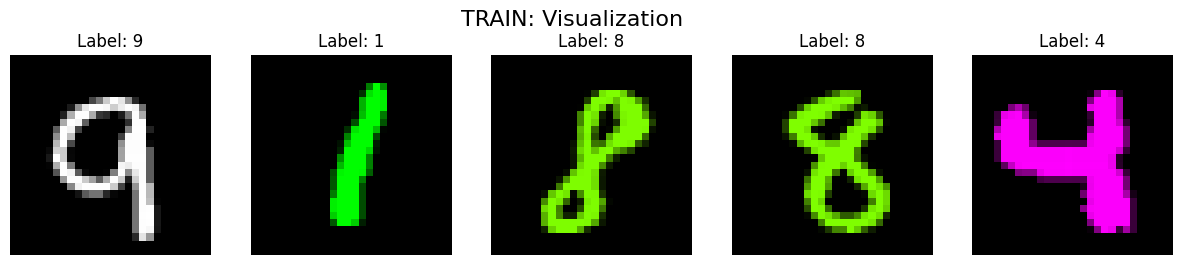

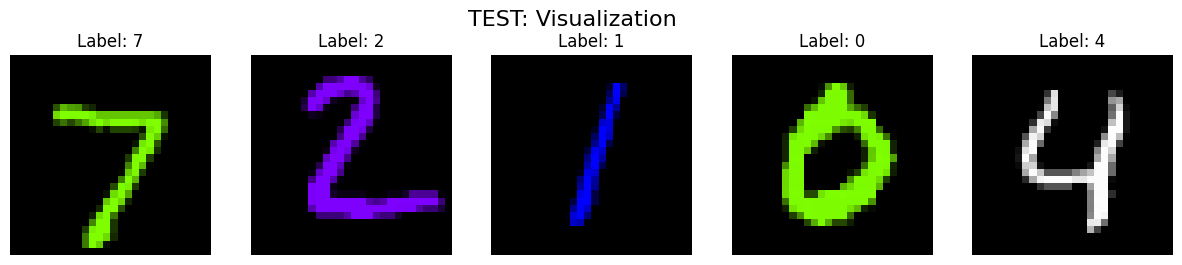

In [43]:
# 6. VISUALIZATION
def show_sample(loader, title):
    data, target = next(iter(loader))
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(title, fontsize=16)
    for i in range(5):
        img = data[i].permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {target[i].item()}")
        axes[i].axis('off')
    plt.show()

print("\nVisualizing what the model saw:")
show_sample(train_loader, "TRAIN: Visualization")
show_sample(test_loader, "TEST: Visualization")

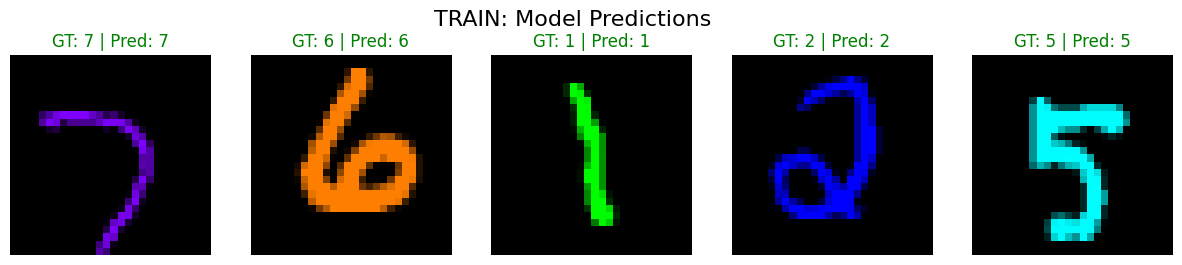

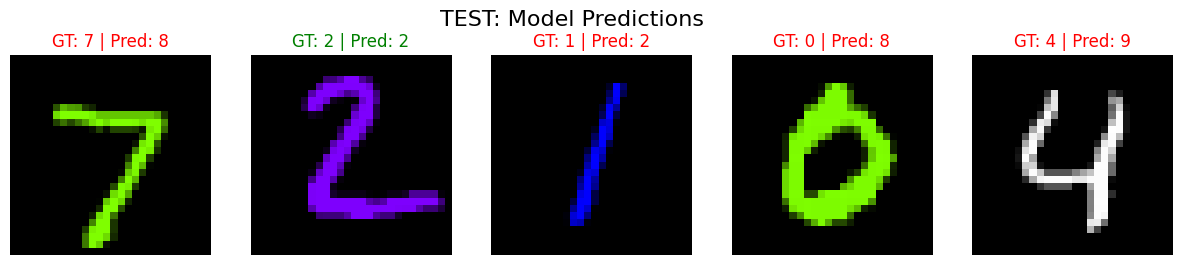

In [44]:
import torch
import matplotlib.pyplot as plt

def show_predictions(loader, model, device, title):
    model.eval()
    data, target = next(iter(loader))
    data, target = data.to(device), target.to(device)

    with torch.no_grad():
        outputs = model(data)
        preds = outputs.argmax(dim=1)

    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(title, fontsize=16)

    for i in range(5):
        img = data[i].cpu().permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(
            f"GT: {target[i].item()} | Pred: {preds[i].item()}",
            color="green" if preds[i] == target[i] else "red"
        )
        axes[i].axis("off")

    plt.show()

show_predictions(train_loader, model, device, "TRAIN: Model Predictions")
show_predictions(test_loader, model, device, "TEST: Model Predictions")


--- Analysis of Image 7 ---
True Digit (Shape): 9
Model Predicted:    5
Confidence:         100.00%

🔴 FAILURE DETECTED
The image is a digit '9'.
But the model predicted '5'.
REASON: The model saw the color (which correlates with '5' in training) and ignored the shape.


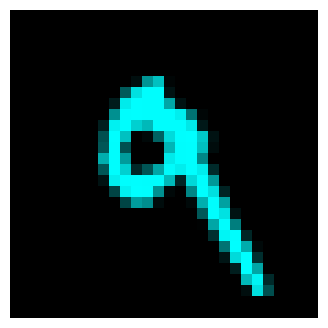

In [45]:
import matplotlib.pyplot as plt
import torch

# 1. Get a batch of images from the Test Loader
# next(iter(...)) grabs the first batch of 64 images
data_batch, label_batch = next(iter(test_loader))

# ---------------------------------------------------------
# CHANGE THIS NUMBER (0 to 63) TO SEE DIFFERENT IMAGES
index = 7
# ---------------------------------------------------------

# 2. Extract the specific image and label
img_tensor = data_batch[index]      # Shape: [3, 28, 28]
true_label = label_batch[index].item() # The actual digit (Shape)

# 3. Prepare for Prediction
# The model expects a batch dimension: [Batch_Size, Channels, Height, Width]
# We add a dimension at index 0 using unsqueeze(0) -> [1, 3, 28, 28]
input_tensor = img_tensor.unsqueeze(0).to(device)

# 4. Get Prediction
model.eval()
with torch.no_grad():
    output = model(input_tensor)

    # Get probabilities to see confidence
    probs = torch.nn.functional.softmax(output, dim=1)
    confidence, predicted_label = torch.max(probs, 1)

# 5. Visualize
plt.figure(figsize=(4, 4))

# We have to swap dimensions for Matplotlib: [C, H, W] -> [H, W, C]
plt.imshow(img_tensor.permute(1, 2, 0).numpy())
plt.axis('off')

# 6. Display Results
print(f"--- Analysis of Image {index} ---")
print(f"True Digit (Shape): {true_label}")
print(f"Model Predicted:    {predicted_label.item()}")
print(f"Confidence:         {confidence.item()*100:.2f}%")

# 7. The "Why" (Automated Explanation)
# Let's verify if the color tricked the model
# Map colors back to the digit they were correlated with during training
color_to_digit_map = {
    (1,0,0): 0, (0,1,0): 1, (0,0,1): 2, (1,1,0): 3, (1,0,1): 4,
    (0,1,1): 5, (1,0.5,0): 6, (0.5,0,1): 7, (0.5,1,0): 8, (1,1,1): 9
}

# Get the dominant color of the image (center pixel)
center_pixel = img_tensor[:, 14, 14].tolist() # RGB values
# Round to nearest simple color for check
approx_color = tuple(round(x) if x != 0.5 else 0.5 for x in center_pixel)

if predicted_label.item() != true_label:
    print("\n🔴 FAILURE DETECTED")
    print(f"The image is a digit '{true_label}'.")
    print(f"But the model predicted '{predicted_label.item()}'.")
    if approx_color in color_to_digit_map:
        spurious_digit = color_to_digit_map[approx_color]
        if predicted_label.item() == spurious_digit:
            print(f"REASON: The model saw the color (which correlates with '{spurious_digit}' in training) and ignored the shape.")
else:
    print("\n🟢 SUCCESS (The model guessed right - usually just luck in this setup)")

# Using ResNet model to check if it improves generalization or not

In [6]:
from torchvision import models

# ---------------------------------------------------------
# 3. REPLACE SIMPLE CNN WITH RESNET-18
# ---------------------------------------------------------
def get_resnet_model():
    # 1. Load Pre-trained ResNet18
    # 'weights="DEFAULT"' loads the ImageNet weights
    model = models.resnet18(weights='DEFAULT')

    # 2. HACK: Modify ResNet for tiny 28x28 images
    # Standard ResNet expects 224x224 images. If we feed 28x28,
    # the internal pooling layers will shrink it to nothing (0x0).

    # Replace the first 7x7 convolution (stride 2) with a 3x3 convolution (stride 1)
    # This keeps the image size large enough for the network to see.
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

    # Remove the first MaxPool layer (it reduces size too much for MNIST)
    model.maxpool = nn.Identity()

    # 3. Modify the Output Layer (The "Head")
    # ResNet18 has 512 features going into the last layer.
    # We change output from 1000 (ImageNet) to 10 (MNIST).
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)

    return model

# Initialize the Model
print("Loading ResNet18 and modifying architecture...")
model = get_resnet_model().to(device)

# Use a smaller learning rate for fine-tuning (standard practice)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# ---------------------------------------------------------
# 4. TRAINING LOOP (Same as before)
# ---------------------------------------------------------
print("\n--- Starting Training (ResNet18) ---")
for epoch in range(5): # ResNet learns FAST
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        running_loss += loss.item()

    print(f"Epoch {epoch+1} | Train Acc: {100 * correct / total:.2f}% | Loss: {running_loss/len(train_loader):.4f}")

# ---------------------------------------------------------
# 5. TEST LOOP (The Reality Check)
# ---------------------------------------------------------
print("\n--- Testing ResNet18 on Out-of-Distribution Data ---")
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"ResNet Test Accuracy (OOD): {100 * correct / total:.2f}%")

Loading ResNet18 and modifying architecture...

--- Starting Training (ResNet18) ---
Epoch 1 | Train Acc: 99.61% | Loss: 0.0156
Epoch 2 | Train Acc: 99.89% | Loss: 0.0041
Epoch 3 | Train Acc: 99.95% | Loss: 0.0021
Epoch 4 | Train Acc: 99.94% | Loss: 0.0027
Epoch 5 | Train Acc: 99.96% | Loss: 0.0016

--- Testing ResNet18 on Out-of-Distribution Data ---
ResNet Test Accuracy (OOD): 10.31%


In [7]:
import matplotlib.pyplot as plt
import torch

# 1. Get a batch of images from the Test Loader
# next(iter(...)) grabs the first batch of 64 images
data_batch, label_batch = next(iter(test_loader))

# ---------------------------------------------------------
# CHANGE THIS NUMBER (0 to 63) TO SEE DIFFERENT IMAGES
index = 19
# ---------------------------------------------------------

# 2. Extract the specific image and label
img_tensor = data_batch[index]      # Shape: [3, 28, 28]
true_label = label_batch[index].item() # The actual digit (Shape)

# 3. Prepare for Prediction
# The model expects a batch dimension: [Batch_Size, Channels, Height, Width]
# We add a dimension at index 0 using unsqueeze(0) -> [1, 3, 28, 28]
input_tensor = img_tensor.unsqueeze(0).to(device)

# 4. Get Prediction
model.eval()
with torch.no_grad():
    output = model(input_tensor)

    # Get probabilities to see confidence
    probs = torch.nn.functional.softmax(output, dim=1)
    confidence, predicted_label = torch.max(probs, 1)

# 5. Visualize
plt.figure(figsize=(4, 4))

# We have to swap dimensions for Matplotlib: [C, H, W] -> [H, W, C]
plt.imshow(img_tensor.permute(1, 2, 0).numpy())
plt.axis('off')

# 6. Display Results
print(f"--- Analysis of Image {index} ---")
print(f"True Digit (Shape): {true_label}")
print(f"Model Predicted:    {predicted_label.item()}")
print(f"Confidence:         {confidence.item()*100:.2f}%")

# 7. The "Why" (Automated Explanation)
# Let's verify if the color tricked the model
# Map colors back to the digit they were correlated with during training
color_to_digit_map = {
    (1,0,0): 0, (0,1,0): 1, (0,0,1): 2, (1,1,0): 3, (1,0,1): 4,
    (0,1,1): 5, (1,0.5,0): 6, (0.5,0,1): 7, (0.5,1,0): 8, (1,1,1): 9
}

# Get the dominant color of the image (center pixel)
center_pixel = img_tensor[:, 14, 14].tolist() # RGB values
# Round to nearest simple color for check
approx_color = tuple(round(x) if x != 0.5 else 0.5 for x in center_pixel)

if predicted_label.item() != true_label:
    print("\n🔴 FAILURE DETECTED")
    print(f"The image is a digit '{true_label}'.")
    print(f"But the model predicted '{predicted_label.item()}'.")
    if approx_color in color_to_digit_map:
        spurious_digit = color_to_digit_map[approx_color]
        if predicted_label.item() == spurious_digit:
            print(f"REASON: The model saw the color (which correlates with '{spurious_digit}' in training) and ignored the shape.")
else:
    print("\n🟢 SUCCESS (The model guessed right - usually just luck in this setup)")

IndexError: index 19 is out of bounds for dimension 0 with size 16

In [8]:
# Save the model's state_dict
torch.save(model.state_dict(), "Resnet18.pth")

# Following the Invariant Risk Minimization Approach where we will techniques of causal inference

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torch.autograd as autograd

# 1. SETUP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64

# 2. DATA GENERATION WITH ENVIRONMENTS
# We need to control the "Correlation Strength" (how much color lies)
def get_biased_mnist(env_name, correlation_prob):
    """
    correlation_prob:
       1.0 = Color predicts label perfectly (Spurious)
       0.5 = Color is random (No spurious correlation)
       0.1 = Color lies (Reverse correlation)
    """
    dataset = datasets.MNIST('./data', train=True, download=True)
    images = dataset.data.float() / 255.0
    labels = dataset.targets

    # 0=Red, 1=Green...
    color_map = torch.tensor([
        [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0],
        [1.0, 1.0, 0.0], [1.0, 0.0, 1.0], [0.0, 1.0, 1.0],
        [1.0, 0.5, 0.0], [0.5, 0.0, 1.0], [0.5, 1.0, 0.0],
        [1.0, 1.0, 1.0]
    ])

    images_rgb = images.unsqueeze(1).repeat(1, 3, 1, 1)

    # ASSIGN COLORS BASED ON PROBABILITY
    final_colors = torch.zeros(len(labels), 3)

    for i in range(len(labels)):
        label = labels[i]
        # Roll a die
        if torch.rand(1).item() < correlation_prob:
            # Spurious Case: Color = Label
            final_colors[i] = color_map[label]
        else:
            # Random Case: Color = Random
            rand_idx = torch.randint(0, 10, (1,)).item()
            final_colors[i] = color_map[rand_idx]

    final_colors = final_colors.view(-1, 3, 1, 1)
    images_rgb = images_rgb * final_colors

    print(f"Created {env_name}: Correlation Strength = {correlation_prob*100}%")
    return torch.utils.data.TensorDataset(images_rgb, labels)

# --- CREATE TWO ENVIRONMENTS + TEST ---
# Env 1: 90% of the time, Color matches Label
dataset_env1 = get_biased_mnist("Environment 1", correlation_prob=0.90)

# Env 2: 80% of the time, Color matches Label (Slightly different statistics)
dataset_env2 = get_biased_mnist("Environment 2", correlation_prob=0.80)

# Test: 10% (The Trap - Colors are mostly wrong/random)
dataset_test = get_biased_mnist("Test Set", correlation_prob=0.10)

loader_env1 = torch.utils.data.DataLoader(dataset_env1, batch_size=BATCH_SIZE, shuffle=True)
loader_env2 = torch.utils.data.DataLoader(dataset_env2, batch_size=BATCH_SIZE, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

# 3. THE IRM MODEL (Needs to be simple to calculate gradients easily)
class IRM_CNN(nn.Module):
    def __init__(self):
        super(IRM_CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        features = self.features(x)
        features = features.view(features.shape[0], -1)
        logits = self.classifier(features)
        return logits

model = IRM_CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. THE MAGIC: IRM PENALTY FUNCTION
def compute_irm_penalty(loss_1, loss_2, dummy_w):
    # This calculates the gradient of the loss with respect to a "dummy" classifier
    # If the representation is truly causal, this gradient should be zero across environments.
    grad_1 = autograd.grad(loss_1.mean(), dummy_w, create_graph=True)[0]
    grad_2 = autograd.grad(loss_2.mean(), dummy_w, create_graph=True)[0]
    result = torch.sum(grad_1 ** 2) + torch.sum(grad_2 ** 2)
    return result

# 5. CAUSAL TRAINING LOOP
print("\n--- Starting IRM Training ---")
# IRM needs a dummy multiplier (fixed at 1.0) to calculate gradients through
dummy_w = torch.nn.Parameter(torch.Tensor([1.0])).to(device)

for epoch in range(15):
    model.train()
    total_loss = 0
    total_penalty = 0

    # Zip the two environments together
    for (data1, target1), (data2, target2) in zip(loader_env1, loader_env2):
        data1, target1 = data1.to(device), target1.to(device)
        data2, target2 = data2.to(device), target2.to(device)

        optimizer.zero_grad()

        # Forward pass both environments
        logits1 = model(data1)
        logits2 = model(data2)

        # Calculate standard error (CrossEntropy)
        # We multiply by dummy_w to allow gradient calculation
        loss1 = nn.functional.cross_entropy(logits1 * dummy_w, target1, reduction='none')
        loss2 = nn.functional.cross_entropy(logits2 * dummy_w, target2, reduction='none')

        # 1. Empirical Risk (Standard Loss)
        risk = loss1.mean() + loss2.mean()

        # 2. Invariance Penalty (The Causal Part)
        # We start applying penalty only after epoch 5 (let it learn features first)
        penalty_weight = 1000.0 if epoch > 5 else 0.0
        penalty = compute_irm_penalty(loss1, loss2, dummy_w)

        # Total Loss
        loss = risk + penalty_weight * penalty

        loss.backward()
        optimizer.step()

        total_loss += risk.item()
        total_penalty += penalty.item()

    print(f"Epoch {epoch+1} | Risk: {total_loss:.2f} | Penalty: {total_penalty:.4f}")

# 6. TEST
print("\n--- Testing IRM on Out-of-Distribution Data ---")
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in loader_test:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"IRM Test Accuracy (OOD): {100 * correct / total:.2f}%")

Created Environment 1: Correlation Strength = 90.0%
Created Environment 2: Correlation Strength = 80.0%
Created Test Set: Correlation Strength = 10.0%

--- Starting IRM Training ---
Epoch 1 | Risk: 275.71 | Penalty: 15.0459
Epoch 2 | Risk: 65.14 | Penalty: 2.3069
Epoch 3 | Risk: 45.60 | Penalty: 1.6342
Epoch 4 | Risk: 33.57 | Penalty: 1.1725
Epoch 5 | Risk: 25.25 | Penalty: 0.8290
Epoch 6 | Risk: 20.43 | Penalty: 0.5856
Epoch 7 | Risk: 100.21 | Penalty: 3.5607
Epoch 8 | Risk: 27.93 | Penalty: 0.5064
Epoch 9 | Risk: 22.80 | Penalty: 0.3599
Epoch 10 | Risk: 25.45 | Penalty: 0.5063
Epoch 11 | Risk: 23.75 | Penalty: 0.4955
Epoch 12 | Risk: 24.70 | Penalty: 0.4868
Epoch 13 | Risk: 22.27 | Penalty: 0.4433
Epoch 14 | Risk: 22.84 | Penalty: 0.4052
Epoch 15 | Risk: 19.04 | Penalty: 0.3758

--- Testing IRM on Out-of-Distribution Data ---
IRM Test Accuracy (OOD): 97.61%


In [67]:
# Save the model's state_dict
torch.save(model.state_dict(), "IRM_cnn.pth")